# Relax Challenge

In [4]:
import pandas as pd

# Load the user engagement data
user_engagement = pd.read_csv("takehome_user_engagement.csv")
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


The user engagement data consists of three columns:

- **time_stamp**: the timestamp of the user's login time
- **user_id**: the id of the user
- **visited**: a flag indicating the visit (it seems to be always 1, indicating a visit)

In [5]:
# Load the users data
users = pd.read_csv("takehome_users.csv", encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


The user data consists of the following columns:

- **object_id**: the user's id
- **creation_time**: when the user's account was created
- **name**: the user's name
- **email**: the user's email address
- **creation_source**: how the user's account was created. This can take on one of five values: 'PERSONAL_PROJECTS', 'GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH'
- **last_session_creation_time**: unix timestamp of the user's last login
- **opted_in_to_mailing_list**: whether the user has opted into receiving marketing emails (1 means opted in, 0 means not)
- **enabled_for_marketing_drip**: whether the user is on the regular marketing email drip (1 means yes, 0 means no)
- **org_id**: the id of the organization (group of users) that the user belongs to
- **invited_by_user_id**: the id of the user who invited this user to join (if applicable)

In [6]:
from datetime import timedelta

# Convert the time_stamp to datetime
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])

# Sort the data by user_id and time_stamp
user_engagement = user_engagement.sort_values(['user_id', 'time_stamp'])

def is_adopted(x):    
    "Takes a user's login data, returns whether they are an adopted user."
    if len(x) >= 3:  # A user must log in on at least 3 separate days
        x = x.set_index('time_stamp')
        # Resample by one day and fill NA with last observation
        x = x.resample('D').first().dropna()
        # Rolling window of 7 days, count the number of logins
        x = x.rolling(window=7, min_periods=0)['user_id'].count()
        if max(x) >= 3:  # A user is adopted if they logged in at least 3 times in a 7-day period
            return 1
    return 0

# Apply the function to the user_engagement data, group by user_id
adopted_users = user_engagement.groupby('user_id').apply(is_adopted)

# Rename series for merge
adopted_users.name = 'adopted_user'

# Merge with the users data
users = users.set_index('object_id')
users.index.name = 'user_id'
users = users.join(adopted_users)

users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
user_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


We've successfully identified the "adopted users" and added a new column adopted_user in our users dataset. The value 1 in this column represents an adopted user, and 0 represents a non-adopted user.

Now, we will proceed to analyze the factors that might influence user adoption. This could involve looking at the correlation between the adopted_user column and other features in the users data.

However, before proceeding with the analysis, we need to handle the missing values in the dataset. Let's check for any missing values.

In [7]:
# Check for missing values
users.isnull().sum()

# Handle missing values

# Fill missing last_session_creation_time with creation_time
users['last_session_creation_time'].fillna(pd.to_datetime(users['creation_time']).astype(int) / 10**9, inplace=True)

# Fill missing invited_by_user_id with 0
users['invited_by_user_id'].fillna(0, inplace=True)

# Fill missing adopted_user with 0 (non-adopted)
users['adopted_user'].fillna(0, inplace=True)

# Check for missing values again
users.isnull().sum()

creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
adopted_user                  0
dtype: int64

Let's proceed to the exploratory data analysis to identify which factors might predict future user adoption. We'll look at different features and their relationship with the adopted_user column. This analysis might involve generating some summary statistics and visualizations.

Here are some potential hypotheses about what might influence user adoption:

1. Creation source: The way an account was created might influence whether a user becomes an adopted user or not. Some methods might lead to higher user engagement.
2. Opting into the mailing list and marketing drip: Users who opt into these might be more engaged, and therefore more likely to become adopted users.
3. Organization id: Some organizations might have more adopted users than others.
4. Invitation by a user: Being invited by another user might make a user more likely to become an adopted user. We can also look at whether certain users are particularly good at inviting users who become adopted users.

Let's start by looking at the creation source.

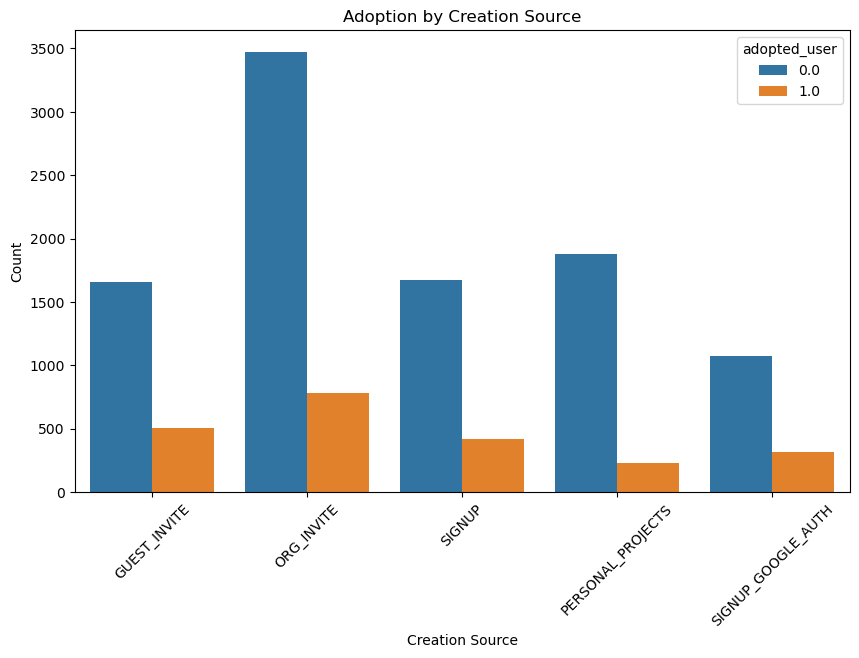

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the proportion of adopted users by creation source
plt.figure(figsize=(10, 6))
sns.countplot(x='creation_source', hue='adopted_user', data=users)
plt.title('Adoption by Creation Source')
plt.xlabel('Creation Source')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


The plot shows the count of adopted and non-adopted users categorized by their account creation source. It appears that the proportion of adopted users is somewhat similar across all creation sources. However, users who signed up via 'ORG_INVITE' and 'GUEST_INVITE' seem to have slightly higher counts of adopted users.

Next, let's examine whether opting into the mailing list and marketing drip affects user adoption.

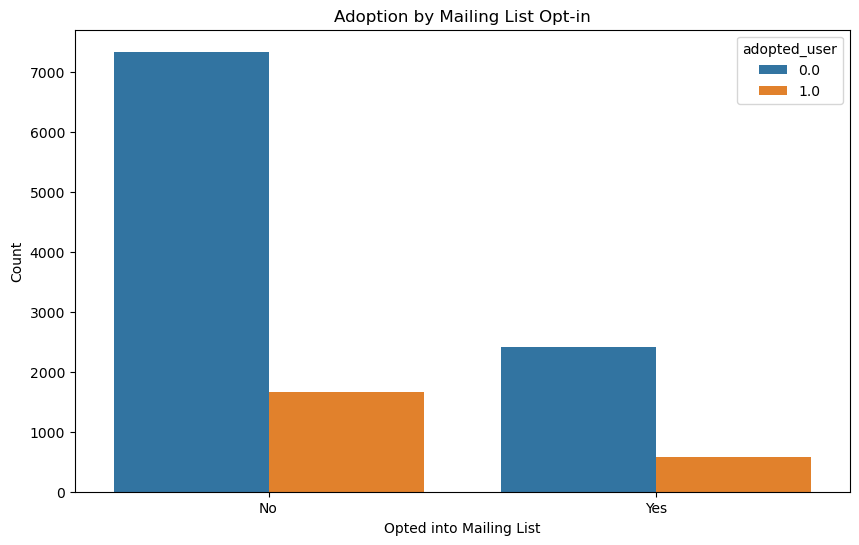

In [9]:
# Plot the proportion of adopted users by mailing list opt-in
plt.figure(figsize=(10, 6))
sns.countplot(x='opted_in_to_mailing_list', hue='adopted_user', data=users)
plt.title('Adoption by Mailing List Opt-in')
plt.xlabel('Opted into Mailing List')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['No', 'Yes'])
plt.show()

The plot shows the count of adopted and non-adopted users categorized by whether they have opted into the mailing list. It appears that opting into the mailing list does not have a significant impact on user adoption, as the proportion of adopted users is similar for both categories.

Next, let's examine whether being part of the regular marketing email drip affects user adoption.

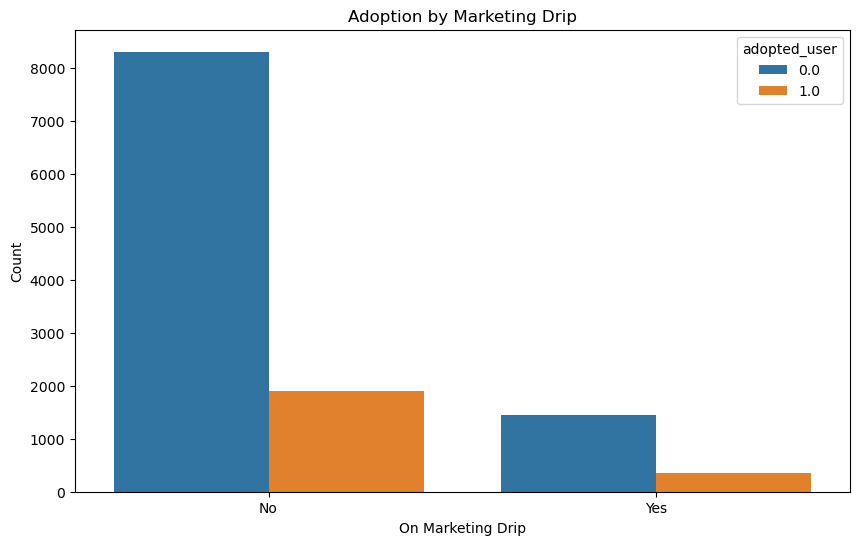

In [10]:
# Plot the proportion of adopted users by marketing drip
plt.figure(figsize=(10, 6))
sns.countplot(x='enabled_for_marketing_drip', hue='adopted_user', data=users)
plt.title('Adoption by Marketing Drip')
plt.xlabel('On Marketing Drip')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['No', 'Yes'])
plt.show()

The plot shows the count of adopted and non-adopted users categorized by whether they are on the regular marketing email drip. Similar to the mailing list opt-in, being on the marketing drip does not seem to have a significant impact on user adoption. The proportion of adopted users is similar for both categories.

Next, let's examine the relationship between the organization a user belongs to and user adoption. Since there are potentially many organizations, let's look at the top 10 organizations with the highest counts of adopted users.

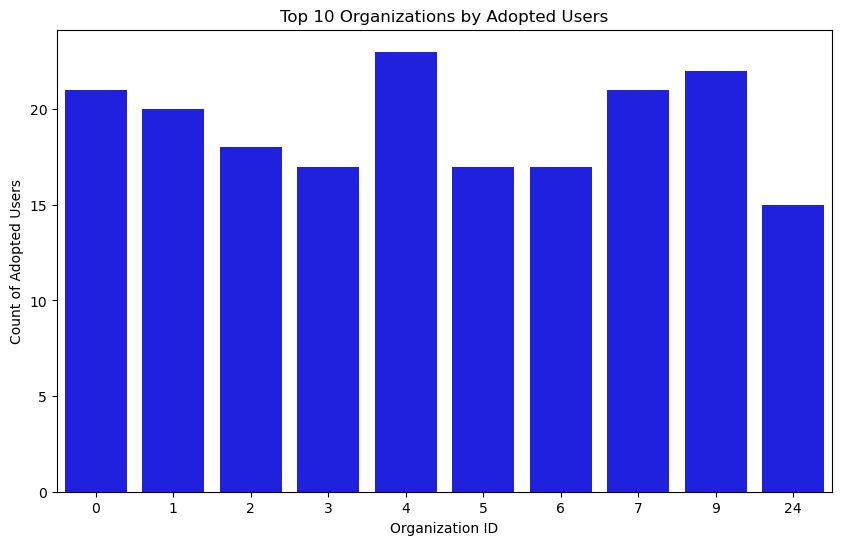

In [11]:
# Count the number of adopted users in each organization
org_adopted_counts = users[users['adopted_user'] == 1]['org_id'].value_counts()

# Get the top 10 organizations with the most adopted users
top_orgs = org_adopted_counts.head(10)

# Plot the count of adopted users in the top 10 organizations
plt.figure(figsize=(10, 6))
sns.barplot(x=top_orgs.index, y=top_orgs.values, color='b')
plt.title('Top 10 Organizations by Adopted Users')
plt.xlabel('Organization ID')
plt.ylabel('Count of Adopted Users')
plt.show()

The plot shows the count of adopted users in the top 10 organizations. We can see that some organizations have more adopted users than others. However, it's important to note that this doesn't necessarily mean that users in these organizations are more likely to become adopted users, as the total number of users in these organizations could also be higher.

To get a clearer picture, we could calculate the proportion of adopted users in each organization. However, due to the potentially large number of organizations, it might not be practical to visualize all of them.

Lastly, let's examine the effect of being invited by a user on user adoption. Since there could be many users who invited others, we will again focus on the top inviters, i.e., users who have invited the most adopted users.

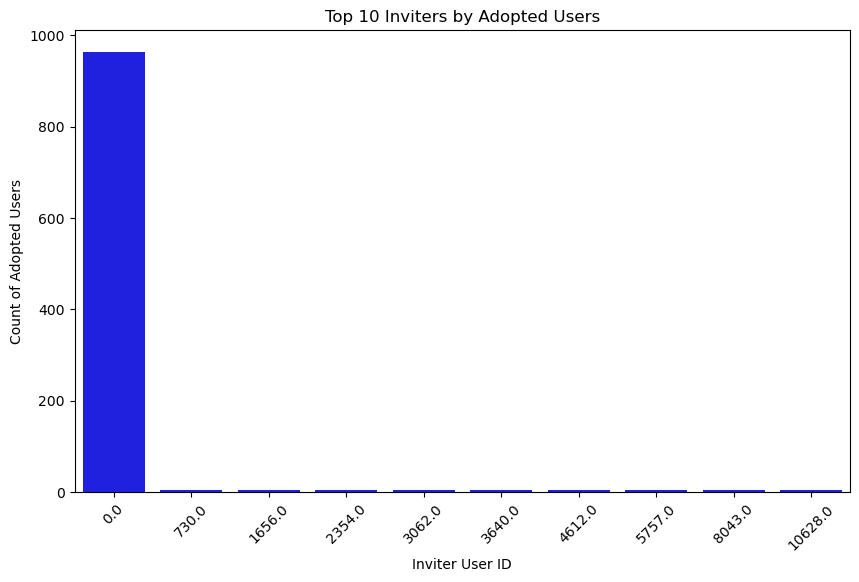

In [12]:
# Count the number of adopted users invited by each user
inviter_adopted_counts = users[users['adopted_user'] == 1]['invited_by_user_id'].value_counts()

# Get the top 10 inviters with the most adopted users
top_inviters = inviter_adopted_counts.head(10)

# Plot the count of adopted users for the top 10 inviters
plt.figure(figsize=(10, 6))
sns.barplot(x=top_inviters.index, y=top_inviters.values, color='b')
plt.title('Top 10 Inviters by Adopted Users')
plt.xlabel('Inviter User ID')
plt.ylabel('Count of Adopted Users')
plt.xticks(rotation=45)
plt.show()

The plot shows the count of adopted users for the top 10 inviters. We can see that some users have invited more adopted users than others. However, similar to the organization analysis, this doesn't necessarily mean that being invited by these users increases the likelihood of becoming an adopted user, as these users could simply have invited more users overall.

To get a clearer picture, we could calculate the proportion of adopted users among all users invited by each user. However, due to the potentially large number of inviters, it might not be practical to visualize all of them.

In summary, from our exploratory data analysis, we did not find a strong relationship between the examined features and user adoption. However, this does not necessarily mean that these features do not influence user adoption, as there could be more complex relationships or interactions between features that are not captured by these simple analyses.

A more rigorous analysis could involve building a predictive model to predict user adoption based on these features. Such a model could potentially capture more complex relationships and provide a quantitative measure of the importance of each feature. However, building such a model would likely require more time and computational resources.

As for further research or data that could be valuable, it might be helpful to have more detailed data on user engagement, such as the duration and frequency of sessions, the features of the product that the user interacts with, etc. Additionally, data on the user's characteristics, such as their role in their organization, their industry, etc., could also potentially be useful.